In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict, Counter

/home/ssaral/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Path to the images
image_file_path = "./img/kodim02.png"

# Function to load images in grayscale
def load_images(image_file_path, target_size=(512, 512)):
    # images = []
    img = Image.open(image_file_path).convert("L")  # Convert to grayscale
    img = img.resize(target_size)  # Resize to target size
    # images.append(np.array(img))
    return np.array(img)

# Load images
images = load_images(image_file_path)

In [3]:
print(images.shape)

(512, 512)


Image info: Mode: RGB, Size: 768x512, Bit depth: N/A


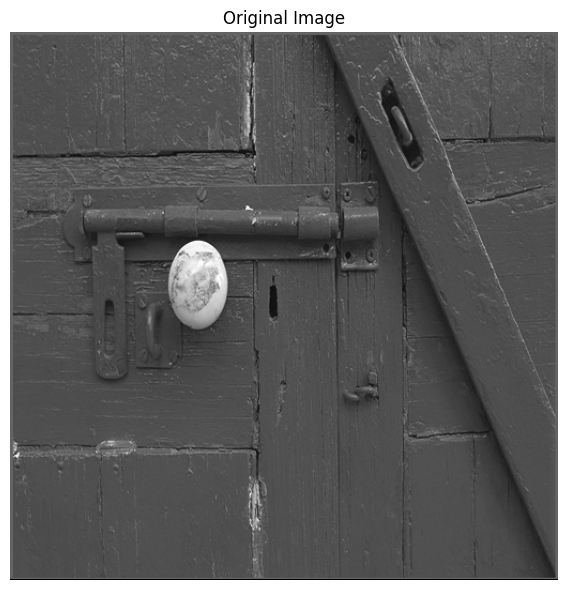

Image info: Mode: L (Grayscale), Size: 512x512, Bit depth: 8


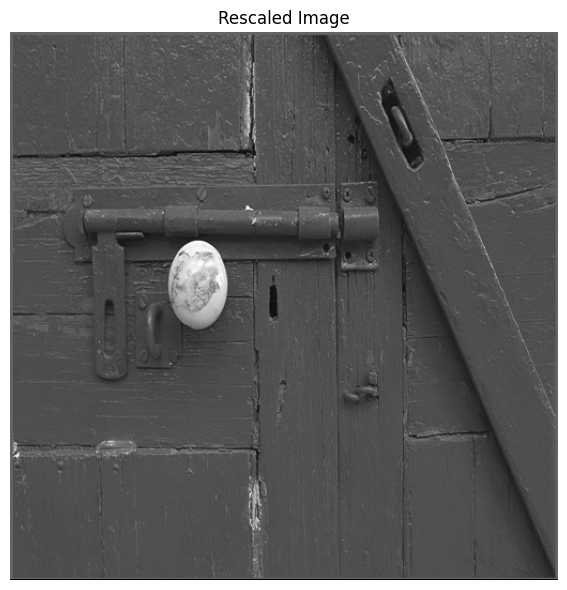

In [4]:
# Displaying original image information
def display_image_info(image_path):
    try:
        img = Image.open(image_path)
        mode = img.mode # mode=(RGB:color_images, L:grayscale)
        size = img.size # size=(width, height)
        bit_depth = img.bits if hasattr(img, 'bits') else 'N/A' # bit depth=(8-bit for "L", 24-bit for "RGB")
        return f"Mode: {mode}, Size: {size[0]}x{size[1]}, Bit depth: {bit_depth}"
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return "Error loading image"

# Display a few images to verify
plt.figure(figsize=(12, 6))
plt.imshow(images, cmap="gray")
plt.title(f"Original Image")
plt.axis("off")  
image_info = display_image_info(image_file_path)
print(f"Image info: {image_info}")
plt.tight_layout()
plt.show()


def display_image_info_from_array(image_array):
    # Checking the image mode is grayscale (mode 'L' in PIL corresponds to single channel)
    if len(image_array.shape) == 2:
        mode = 'L (Grayscale)'
        bit_depth = 8  
    elif len(image_array.shape) == 3 and image_array.shape[2] == 3:
        mode = 'RGB (Color)'
        bit_depth = 24 
    else:
        mode = 'Unknown'
        bit_depth = 'N/A'
        
    size = image_array.shape[:2]  # first two dimensions (height, width)
    return f"Mode: {mode}, Size: {size[1]}x{size[0]}, Bit depth: {bit_depth}"

plt.figure(figsize=(12, 6))
plt.imshow(images, cmap="gray")
plt.title(f"Rescaled Image")
plt.axis("off")
image_info = display_image_info_from_array(images)
print(f"Image info: {image_info}")
plt.tight_layout()
plt.show()

In [5]:
from scipy.fftpack import dct, idct

In [6]:
# divide an image into 8x8 blocks
def divide_into_blocks(image, block_size=8):
    h, w = image.shape
    assert h % block_size == 0 and w % block_size == 0, "Image dimensions must be divisible by block size."
    blocks = []
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            blocks.append(block)
    return np.array(blocks)

# compute 2D DCT for each block
def compute_dct(blocks):
    dct_blocks = []
    for block in blocks:
        # Apply 2D DCT
        dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
        dct_blocks.append(dct_block)
    return np.array(dct_blocks)

# Process all images
blocks = divide_into_blocks(images)  # Divide into 8x8 blocks
dct_blocks = compute_dct(blocks)  # Compute DCT for each block
print(f"{dct_blocks}")

# Verify with the first image
first_image_dct = dct_blocks

[[[ 7.34750000e+02  3.32745989e+01  2.49339654e+01 ... -5.26171424e+00
    4.01371001e+00  4.86912074e+00]
  [ 3.77817912e+01 -2.37850881e+01 -1.25158500e+01 ...  4.78867843e+00
   -4.36581391e+00 -1.84516939e+00]
  [ 9.14594075e+00  5.03044729e-02 -1.46835047e+01 ...  1.42395742e+00
    1.16789322e+00 -3.17061003e+00]
  ...
  [-9.24588357e+00  1.07883585e+01 -6.18232824e+00 ...  1.48626728e+00
    2.84245930e-01 -4.88067615e-01]
  [ 3.78837270e+00 -1.85627215e+00 -2.58210678e+00 ... -2.69487035e+00
    1.93350468e+00 -1.24917237e+00]
  [ 8.84409957e+00 -7.65062574e+00  1.14041057e+00 ...  5.45587380e-01
   -6.30048069e-01 -3.51843672e-01]]

 [[ 7.04000000e+02  8.88779982e+00  9.37691064e+00 ...  4.50010908e+00
    3.69270184e+00  1.64044441e+00]
  [ 5.85824714e+01 -7.25936542e+00 -1.09272504e+01 ... -3.96274546e+00
   -2.07042445e+00 -3.76262790e-02]
  [ 1.82522533e+01 -1.74345471e+00 -8.10660172e-01 ... -6.46765696e-01
   -7.07106781e-01 -2.20218319e+00]
  ...
  [-4.57215435e+00  3.9

In [7]:
print(dct_blocks.shape)

(4096, 8, 8)


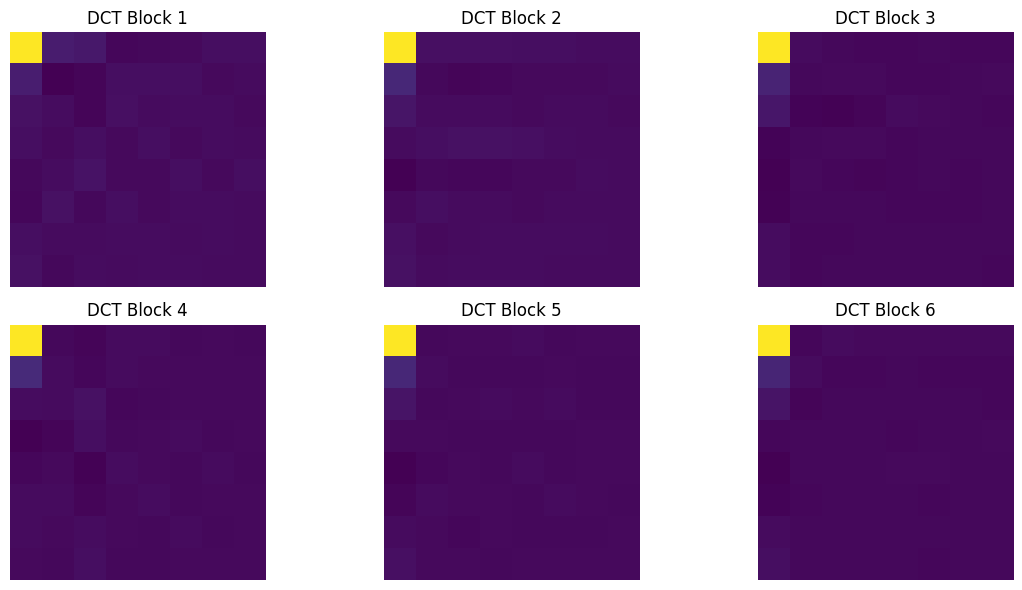

In [8]:
# Display the first few DCT blocks
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(first_image_dct[i])#, cmap="gray")
    plt.title(f"DCT Block {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
# Default quantization table
default_quantization_table = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# For scaling quantization table by quality factor
def scale_quantization_table(table, quality_factor):
    if quality_factor < 1: quality_factor = 1
    if quality_factor > 100: quality_factor = 100
    scale = 50 / quality_factor if quality_factor < 50 else (100 - quality_factor) / 50
    scaled_table = np.clip(np.round(table * scale), 1, 255)  # Ensuring the values stay within [1, 255]
    return scaled_table

# Function to quantize DCT coefficients
def quantize_dct(dct_blocks, quant_table):
    quantized_blocks = []
    for block in dct_blocks:
        quantized_block = np.round(block / quant_table).astype(int)  # Quantize
        quantized_blocks.append(quantized_block)
    return np.array(quantized_blocks)

quality_factor = 50  # For adjusting quality factor
scaled_table = scale_quantization_table(default_quantization_table, quality_factor)

# quantized_blocks = quantize_all_dct(all_dct_blocks[0], scaled_table)
quantized_blocks = quantize_dct(dct_blocks, scaled_table)


In [10]:
print(quantized_blocks.shape)

(4096, 8, 8)


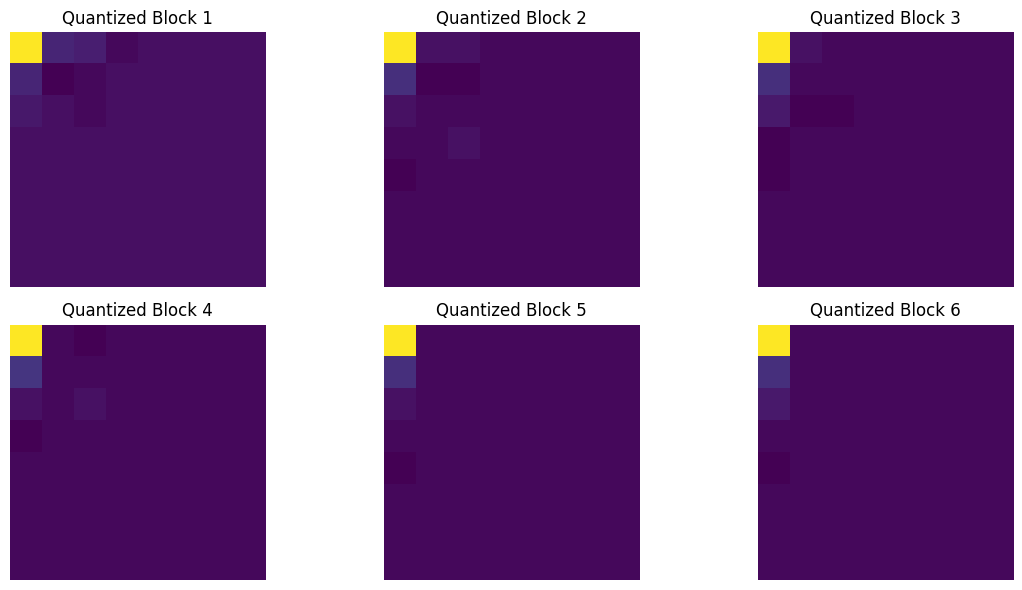

In [11]:
# Display first few quantized blocks for verification
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(quantized_blocks[i]) #, cmap="gray")
    plt.title(f"Quantized Block {i + 1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
print(f"{dct_blocks[0]} \n {quantized_blocks[0]}")

[[ 7.34750000e+02  3.32745989e+01  2.49339654e+01 -1.05134246e+01
  -8.50000000e+00 -5.26171424e+00  4.01371001e+00  4.86912074e+00]
 [ 3.77817912e+01 -2.37850881e+01 -1.25158500e+01  4.18987850e+00
   5.74444598e+00  4.78867843e+00 -4.36581391e+00 -1.84516939e+00]
 [ 9.14594075e+00  5.03044729e-02 -1.46835047e+01  8.37577861e+00
  -7.55751459e-01  1.42395742e+00  1.16789322e+00 -3.17061003e+00]
 [ 2.90805650e+00 -5.01839770e+00  4.69803425e+00 -3.34933548e+00
   5.22929422e+00 -5.85720681e+00  2.59271422e+00 -6.44067413e-01]
 [-7.75000000e+00  1.90602795e-01  1.20268484e+01 -5.33496390e+00
  -4.00000000e+00  3.78665640e+00 -3.62869349e+00  3.74674046e+00]
 [-9.24588357e+00  1.07883585e+01 -6.18232824e+00  3.83733684e+00
  -3.33955717e+00  1.48626728e+00  2.84245930e-01 -4.88067615e-01]
 [ 3.78837270e+00 -1.85627215e+00 -2.58210678e+00  7.03473737e-01
   2.74842495e+00 -2.69487035e+00  1.93350468e+00 -1.24917237e+00]
 [ 8.84409957e+00 -7.65062574e+00  1.14041057e+00 -1.31900851e+00
   

In [13]:
for block in quantized_blocks:
        print(block.flatten())

[46  3  2 -1  0  0  0  0  3 -2 -1  0  0  0  0  0  1  0 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[44  1  1  0  0  0  0  0  5 -1 -1  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[44  1  0  0  0  0  0  0  5  0  0  0  0  0  0  0  2 -1 -1  0  0  0  0  0
 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[44  0 -1  0  0  0  0  0  6  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0
 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[44  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[44  0  0  0  0  0  

In [14]:
# Step 1: Flatten quantized coefficients into a 1D array for all images
def flatten_quantized_blocks(quantized_blocks):
    flattened_data = []
    for block in quantized_blocks:
        flattened_data.extend(block.flatten())
    return flattened_data

# Step 2: Build the frequency table
def build_frequency_table(data):
    return Counter(data)

# Step 3: Build the Huffman tree
class HuffmanNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol  # The quantized value
        self.freq = freq      # Frequency of the symbol
        self.left = None      # Left child in the tree
        self.right = None     # Right child in the tree
    
    # Define comparison operators for priority queue
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freq_table):
    priority_queue = [HuffmanNode(symbol, freq) for symbol, freq in freq_table.items()]
    heapq.heapify(priority_queue)
    
    while len(priority_queue) > 1:
        left = heapq.heappop(priority_queue)
        right = heapq.heappop(priority_queue)
        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(priority_queue, merged)
    
    return priority_queue[0]  # Root node of the Huffman tree

# Step 4: Generate Huffman codes
def generate_huffman_codes(tree):
    codes = {}
    
    def traverse(node, current_code=""):
        if node.symbol is not None:  # Leaf node
            codes[node.symbol] = current_code
            return
        if node.left: traverse(node.left, current_code + "0")
        if node.right: traverse(node.right, current_code + "1")
    
    traverse(tree)
    return codes

# Step 5: Encode the data
def encode_data(data, codes):
    return ''.join(codes[symbol] for symbol in data)

def huffman_encode(all_quantized_blocks):
    # Step 1: Flatten the quantized blocks
    flattened_data = flatten_quantized_blocks(all_quantized_blocks)

    # Step 2: Build frequency table
    freq_table = build_frequency_table(flattened_data)
    
    # Step 3: Build Huffman tree
    huffman_tree = build_huffman_tree(freq_table)
    
    # Step 4: Generate Huffman codes
    huffman_codes = generate_huffman_codes(huffman_tree)
    
    # Step 5: Encode the data
    encoded_data = encode_data(flattened_data, huffman_codes)
    
    return encoded_data, huffman_tree, huffman_codes

encoded_data, huffman_tree, huffman_codes = huffman_encode(quantized_blocks)


In [15]:
print(type(encoded_data), len(encoded_data))

<class 'str'> 356055


In [16]:
# Print some statistics
print(f"Original size: {len(flatten_quantized_blocks(quantized_blocks)) * 8} bits")
print(f"Encoded size: {len(encoded_data)} bits")
print(f"Compression ratio (Encoded Data/Quantized Block): {len(encoded_data) / (len(flatten_quantized_blocks(quantized_blocks)) * 8):.2f}")

Original size: 2097152 bits
Encoded size: 356055 bits
Compression ratio (Encoded Data/Quantized Block): 0.17


In [17]:
def calculate_sizes_and_ratios(images, all_dct_blocks, all_quantized_blocks, encoded_data):
    # Image size (Original)
    height, width = images.shape
    original_size_bits = height * width * 8  # 8 bits per pixel
    dct_size_bits = height * width * 32  # 32 bits per coefficient
    quantized_size_bits = height * width * 16  # 16 bits per coefficient
    encoded_size_bits = len(encoded_data)  # Size of the compressed bitstream
    
    # Compression Ratios
    dct_ratio = original_size_bits / dct_size_bits
    quantized_ratio = original_size_bits / quantized_size_bits
    encoded_ratio = original_size_bits / encoded_size_bits
    
    print(f"Original Image Size: {original_size_bits / 8 / 1024:.2f} KB")
    print(f"DCT Coefficients Size: {dct_size_bits / 8 / 1024:.2f} KB")
    print(f"Quantized Coefficients Size: {quantized_size_bits / 8 / 1024:.2f} KB")
    print(f"Encoded Data Size: {encoded_size_bits / 8 / 1024:.2f} KB")
    
    print("\nCompression Ratios:")
    print(f"Original to DCT Ratio: {dct_ratio:.2f}")
    print(f"Original to Quantized Ratio: {quantized_ratio:.2f}")
    print(f"Original to Encoded Ratio: {encoded_ratio:.2f}")

calculate_sizes_and_ratios(images, dct_blocks, quantized_blocks, encoded_data)


Original Image Size: 256.00 KB
DCT Coefficients Size: 1024.00 KB
Quantized Coefficients Size: 512.00 KB
Encoded Data Size: 43.46 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 5.89


In [18]:
import pickle

def save_encoded_data(encoded_data, huffman_tree, filename):
    # Serialize the Huffman tree and bitstream using pickle
    with open(filename, 'wb') as f:
        pickle.dump({
            "huffman_tree": huffman_tree,
            "encoded_data": encoded_data
        }, f)

# Save the encoded data
save_encoded_data(encoded_data, huffman_tree, "compressed_image.bin")
print("Compressed data saved to 'compressed_image.bin'")

Compressed data saved to 'compressed_image.bin'


In [19]:
def load_encoded_data(filename):
    # Deserialize the Huffman tree and bitstream
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data["encoded_data"], data["huffman_tree"]

def decode_data(encoded_data, huffman_tree):
    # Decode the bitstream using the Huffman tree
    decoded_symbols = []
    current_node = huffman_tree
    for bit in encoded_data:
        if bit == '0':
            current_node = current_node.left
        else:
            current_node = current_node.right
        
        # Leaf node reached
        if current_node.symbol is not None:
            decoded_symbols.append(current_node.symbol)
            current_node = huffman_tree  # Reset to root
    
    return decoded_symbols

def rebuild_quantized_blocks(decoded_symbols, block_shape=(8, 8), num_blocks=4096):
    # Rebuild the quantized blocks from the decoded symbols
    quantized_blocks = []
    for i in range(num_blocks):
        block_data = decoded_symbols[i * 64:(i + 1) * 64]
        block = np.array(block_data).reshape(block_shape)
        quantized_blocks.append(block)
    return np.array(quantized_blocks)

# Load the encoded data
encoded_data, huffman_tree = load_encoded_data("compressed_image.bin")

# Decode the bitstream into quantized coefficients
decoded_symbols = decode_data(encoded_data, huffman_tree)

# Rebuild quantized blocks for a single image
decoded_quantized_blocks = rebuild_quantized_blocks(decoded_symbols)

print(f"Shape of decoded_quantized_blocks: {decoded_quantized_blocks.shape}")

Shape of decoded_quantized_blocks: (4096, 8, 8)


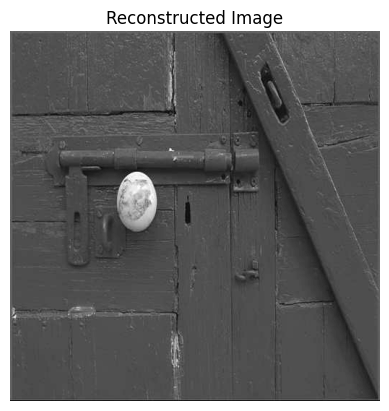

In [20]:
from scipy.fftpack import idct

def inverse_quantization(quantized_blocks, quant_table):
    # Multiply each quantized block by the quantization table
    return np.array([block * quant_table for block in quantized_blocks])

def inverse_dct(reconstructed_blocks):
    # Apply inverse DCT to each block
    return np.array([idct(idct(block.T, norm='ortho').T, norm='ortho') for block in reconstructed_blocks])

def reconstruct_image_from_blocks(blocks, image_shape=(512, 512)):
    # Reassemble the blocks into the original image
    block_size = blocks.shape[1]
    image = np.zeros(image_shape)
    idx = 0
    for i in range(0, image_shape[0], block_size):
        for j in range(0, image_shape[1], block_size):
            image[i:i + block_size, j:j + block_size] = blocks[idx]
            idx += 1
    return np.clip(image, 0, 255).astype(np.uint8)

# Step 1: Inverse quantization
reconstructed_blocks = inverse_quantization(decoded_quantized_blocks, scaled_table)

# Step 2: Inverse DCT
spatial_blocks = inverse_dct(reconstructed_blocks)

# Step 3: Reconstruct the image
reconstructed_image = reconstruct_image_from_blocks(spatial_blocks)

# Display the reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.axis("off")
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_rmse(original_image, reconstructed_image):
    rmse = np.sqrt(mean_squared_error(original_image.flatten(), reconstructed_image.flatten()))
    return rmse

# Calculate RMSE for a single image
rmse = calculate_rmse(images, reconstructed_image)
print(f"RMSE for the reconstructed image: {rmse:.4f}")

RMSE for the reconstructed image: 4.1696


In [22]:
def rmse_vs_bpp_analysis(images, all_dct_blocks, all_quantized_blocks, encoded_data):
    original_size_bits = images.size * 8  # Total bits in original images
    encoded_size_bits = len(encoded_data)  # Compressed size in bits
    bpp = encoded_size_bits / (images.shape[0] * images.shape[1] )  # Bits per pixel
    
    rmses = []
    # for i, image in enumerate(images):
    decoded_symbols = decode_data(encoded_data, huffman_tree)
    decoded_blocks = rebuild_quantized_blocks(decoded_symbols)
    reconstructed_blocks = inverse_quantization(decoded_blocks, scaled_table)
    spatial_blocks = inverse_dct(reconstructed_blocks)
    reconstructed_image = reconstruct_image_from_blocks(spatial_blocks)
    
    # Calculate RMSE
    rmse = calculate_rmse(images, reconstructed_image)
    rmses.append(rmse)
    
    # Average RMSE across all images
    avg_rmse = np.mean(rmses)
    return bpp, avg_rmse

# Perform analysis
bpp, avg_rmse = rmse_vs_bpp_analysis(images, dct_blocks, quantized_blocks, encoded_data)
print(f"Bits Per Pixel (BPP): {bpp:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")


Bits Per Pixel (BPP): 1.3582
Average RMSE: 4.1696


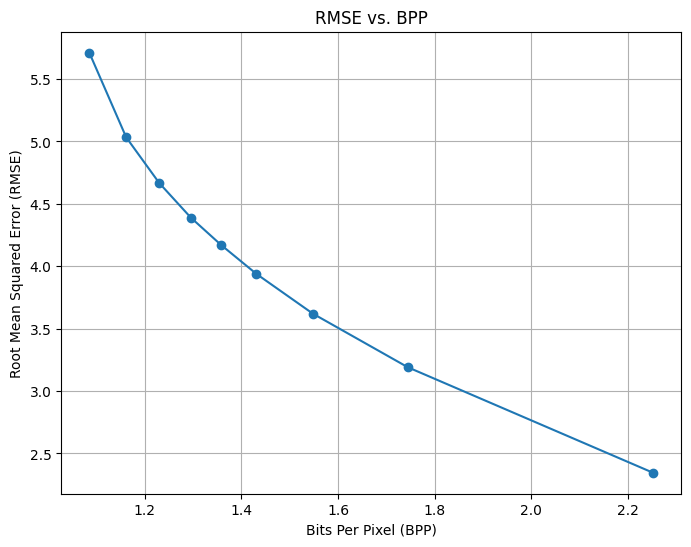

In [23]:
import matplotlib.pyplot as plt

def plot_rmse_vs_bpp(quality_factors, bpps, rmses):
    plt.figure(figsize=(8, 6))
    plt.plot(bpps, rmses, marker='o')
    plt.title("RMSE vs. BPP")
    plt.xlabel("Bits Per Pixel (BPP)")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.grid(True)
    plt.show()

# Example data (simulate RMSE and BPP values for different quality factors)
quality_factors = np.linspace(10, 90, 9)  # Quality factors
bpps = []  # To store calculated BPPs
rmses = []  # To store calculated RMSEs


for qf in quality_factors:
    scaled_table = scale_quantization_table(default_quantization_table, qf) #* (100 - qf) / 50
    all_quantized_blocks = quantize_dct(dct_blocks, scaled_table)
    encoded_data, huffman_tree, huffman_codes = huffman_encode(all_quantized_blocks)
    bpp, avg_rmse = rmse_vs_bpp_analysis(images, dct_blocks, all_quantized_blocks, encoded_data)
    bpps.append(bpp)
    rmses.append(avg_rmse)

# Plot RMSE vs. BPP
plot_rmse_vs_bpp(quality_factors, bpps, rmses)

Compressed data saved to compressed_image.bin
Reconstructed image saved as reconstructed_image.jpg


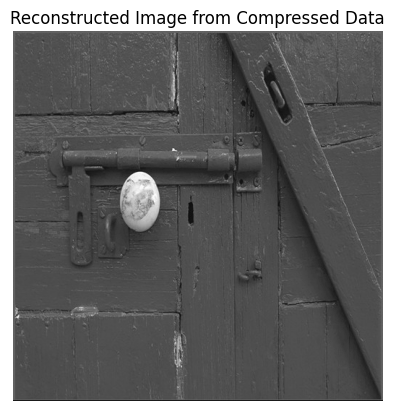

In [24]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import idct

def decode_and_reconstruct_image(encoded_data, huffman_tree, quant_table, image_shape=(512, 512)):
    # Decode the bitstream into quantized coefficients
    decoded_symbols = decode_data(encoded_data, huffman_tree)

    # Rebuild quantized blocks from decoded symbols
    decoded_quantized_blocks = rebuild_quantized_blocks(decoded_symbols)

    # Perform inverse quantization
    reconstructed_blocks = inverse_quantization(decoded_quantized_blocks, quant_table)

    # Apply inverse DCT to get spatial blocks
    spatial_blocks = inverse_dct(reconstructed_blocks)

    # Reconstruct the full image from blocks
    reconstructed_image = reconstruct_image_from_blocks(spatial_blocks, image_shape)

    return reconstructed_image

# Define functions for compression and decompression (based on previous code)

def save_compressed_data(encoded_data, huffman_tree, filename):
    with open(filename, 'wb') as f:
        pickle.dump({
            "huffman_tree": huffman_tree,
            "encoded_data": encoded_data
        }, f)
    print(f"Compressed data saved to {filename}")

def load_compressed_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data["encoded_data"], data["huffman_tree"]

def decode_data(encoded_data, huffman_tree):
    decoded_symbols = []
    current_node = huffman_tree
    for bit in encoded_data:
        current_node = current_node.left if bit == '0' else current_node.right
        if current_node.symbol is not None:
            decoded_symbols.append(current_node.symbol)
            current_node = huffman_tree
    return decoded_symbols

def rebuild_quantized_blocks(decoded_symbols, block_shape=(8, 8), num_blocks=4096):
    quantized_blocks = [np.array(decoded_symbols[i * 64:(i + 1) * 64]).reshape(block_shape) for i in range(num_blocks)]
    return np.array(quantized_blocks)

def inverse_quantization(quantized_blocks, quant_table):
    return np.array([block * quant_table for block in quantized_blocks])

def inverse_dct(reconstructed_blocks):
    return np.array([idct(idct(block.T, norm='ortho').T, norm='ortho') for block in reconstructed_blocks])

def reconstruct_image_from_blocks(blocks, image_shape=(512, 512)):
    image = np.zeros(image_shape)
    idx = 0
    block_size = blocks.shape[1]
    for i in range(0, image_shape[0], block_size):
        for j in range(0, image_shape[1], block_size):
            image[i:i + block_size, j:j + block_size] = blocks[idx]
            idx += 1
    return np.clip(image, 0, 255).astype(np.uint8)

def save_as_jpeg(image, filename="reconstructed_image.jpg"):
    pil_image = Image.fromarray(image)  # Convert numpy array to PIL Image
    pil_image.save(filename, "JPEG")
    print(f"Reconstructed image saved as {filename}")

def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.title("Reconstructed Image from Compressed Data")
    plt.axis("off")
    plt.show()

# --- Main Execution ---
# Step 1: Save the compressed data (Huffman tree + encoded bitstream)
save_compressed_data(encoded_data, huffman_tree, "compressed_image.bin")

# Step 2: Load the compressed data (Huffman tree + encoded bitstream)
encoded_data, huffman_tree = load_compressed_data("compressed_image.bin")

# Step 3: Decode and reconstruct the image
reconstructed_image = decode_and_reconstruct_image(encoded_data, huffman_tree, scaled_table)

# Step 4: Save the reconstructed image as a JPEG file
save_as_jpeg(reconstructed_image, "reconstructed_image.jpg")

# Optional: Display the image if desired
display_image(reconstructed_image)
